# AIAP Past Years Series - Student Score Prediction

## Introduction and Set Up

Background Information: In this hypothetical situation given by AIAP, the objective of this notebook is to build a model that can predict a student's O-level mathematics examination scores to identify weaker students prior to the examination in order to render additional support to weaker students.

Given a dataset (./data/score.db), exploratory data analysis and an end-to-end machine learning pipeline must be built.

The libaries necessary for the above objectives are first imported. I chose Pandas and Numpy to perform operations on dataframes, Seaborn for data visualization, and SQLite to query the given database file.

In [392]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 as sql

In the following blocks, the notebook is connected to the database using SQLite. A query is written obtain the available table names inside the database.

In [393]:
conn = sql.connect("./data/score.db")
cur = conn.cursor()

In [394]:
query = '''
SELECT name FROM sqlite_master
where type='table'
'''
cur.execute(query).fetchall()

[('score',)]

Pandas is then used to execute the query and provide the query results to the DataFrame constructor. The connection is closed after saving the query output into a DataFrame.

In [395]:
query = 'SELECT * from score'
original_df = pd.read_sql_query(query,conn)
df = original_df.copy(deep=True)

In [396]:
conn.close()

In [397]:
df.head()

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color
0,0,0,Yes,Sports,Visual,ACN2BE,Female,No,69.0,14.0,2.0,16.0,10.0,91.0,22:00,6:00,private transport,yellow
1,1,2,No,Sports,Auditory,FGXIIZ,Female,No,47.0,4.0,19.0,16.0,7.0,94.0,22:30,6:30,private transport,green
2,2,0,Yes,None,Visual,B9AI9F,Male,No,85.0,14.0,2.0,15.0,8.0,92.0,22:30,6:30,private transport,white
3,3,1,No,Clubs,Auditory,FEVM1T,Female,Yes,64.0,2.0,20.0,15.0,18.0,NaN,21:00,5:00,public transport,yellow
4,4,0,No,Sports,Auditory,AXZN2E,Male,No,66.0,24.0,3.0,16.0,7.0,95.0,21:30,5:30,public transport,yellow


Now that we have the results in a DataFrame, exploratory data analysis can begin.

## Exploratory Data Analysis

The column explanations are in the PDF file provided:
- student_id: Unique ID for each student
- number_of_siblings: Number of siblings
- direct_admission: Mode of entering the school
- CCA: Enrolled CCA
- learning_style: Primary learning style
- tuition: Whether the student has tuition
- final_test: Student's O-level mathematics examination score
- n_male: Number of male classmates
- n_female: Number of female classmates
- gender: Gender type
- age: Age of the student
- hours_per_week: Number of hours the student studies per week
- attendance_rate: Attendance rate of the student (%)
- sleep_time: Daily sleeping time (hour:minutes)
- wake_time: Daily waking up time (hour:minutes)
- mode_of_transport: Mode of transport to school
- bag_color: Color of the student's bag

### General Information

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15900 entries, 0 to 15899
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               15900 non-null  int64  
 1   number_of_siblings  15900 non-null  int64  
 2   direct_admission    15900 non-null  object 
 3   CCA                 15900 non-null  object 
 4   learning_style      15900 non-null  object 
 5   student_id          15900 non-null  object 
 6   gender              15900 non-null  object 
 7   tuition             15900 non-null  object 
 8   final_test          15405 non-null  float64
 9   n_male              15900 non-null  float64
 10  n_female            15900 non-null  float64
 11  age                 15900 non-null  float64
 12  hours_per_week      15900 non-null  float64
 13  attendance_rate     15122 non-null  float64
 14  sleep_time          15900 non-null  object 
 15  wake_time           15900 non-null  object 
 16  mode

In [399]:
df['final_test'] = df[df['final_test'].notnull()]['final_test'].astype('int')

The following is inferred from the below:
- The index does not give us useful statistical information.
- Students have between 0-2 siblings, with most students (mean and median) having 1 sibling.
- Final test scores range between 32 - 100, with the mean being 67.
- The mean and median for n_male is higher than n_female. Most students have more male classmates than female classmates. 
- The age of the students sitting for O-levels is 15-16.
- Students average 10 hours of studying per week, with a min of 0 hours and max of 20.
- Attendance rates range between 40 - 100, with most students having a 93% attendance rate.

In [400]:
df.describe()

,index,number_of_siblings,final_test,n_male,n_female,age,hours_per_week,attendance_rate
count,15900.000000,15900.000000,15405.000000,15900.000000,15900.000000,15900.000000,15900.000000,15122.000000
mean,7949.500000,0.886541,67.165401,13.880000,8.906038,15.213459,10.312579,93.270268
std,4590.078975,0.751346,13.977879,6.552584,6.663852,1.758941,4.461861,7.984230
min,0.000000,0.000000,32.000000,0.000000,0.000000,-5.000000,0.000000,40.000000
25%,3974.750000,0.000000,56.000000,10.000000,4.000000,15.000000,7.000000,92.000000
50%,7949.500000,1.000000,68.000000,14.000000,8.000000,15.000000,9.000000,95.000000
75%,11924.250000,1.000000,78.000000,18.000000,13.000000,16.000000,14.000000,97.000000
max,15899.000000,2.000000,100.000000,31.000000,31.000000,16.000000,20.000000,100.000000


In the below cells, the DataFrame is checked for missing data. 495 of the final_test scores are missing, and 778 of the attendance_rates are missing. As the final_test is the label to be predicted, the information from the rows that are missing those scores cannot be used by supervised learning algorithms. There are 21 overlaps between the rows with missing data from those two columns. Missing data will need to be handled prior to training the model.

In [401]:
df.isnull().sum()

index                   0
number_of_siblings      0
direct_admission        0
CCA                     0
learning_style          0
student_id              0
gender                  0
tuition                 0
final_test            495
n_male                  0
n_female                0
age                     0
hours_per_week          0
attendance_rate       778
sleep_time              0
wake_time               0
mode_of_transport       0
bag_color               0
dtype: int64

In [402]:
df[df['attendance_rate'].isnull() & df['final_test'].isnull()].count()

index                 21
number_of_siblings    21
direct_admission      21
CCA                   21
learning_style        21
student_id            21
gender                21
tuition               21
final_test             0
n_male                21
n_female              21
age                   21
hours_per_week        21
attendance_rate        0
sleep_time            21
wake_time             21
mode_of_transport     21
bag_color             21
dtype: int64

To have a better idea of the unique values of each column:

In [403]:
df.nunique()

index                 15900
number_of_siblings        3
direct_admission          2
CCA                       8
learning_style            2
student_id            15000
gender                    2
tuition                   4
final_test               68
n_male                   32
n_female                 32
age                       6
hours_per_week           21
attendance_rate          61
sleep_time               13
wake_time                 5
mode_of_transport         3
bag_color                 6
dtype: int64

From here, each column will be explored individually to ensure that the exploratory data analysis is as thorough as possible. student_id and index are not included as they do not contain useful information.

### number_of_siblings

In [404]:
df['number_of_siblings'].value_counts()

number_of_siblings
1    6720
0    5492
2    3688
Name: count, dtype: int64

<Axes: xlabel='number_of_siblings', ylabel='count'>

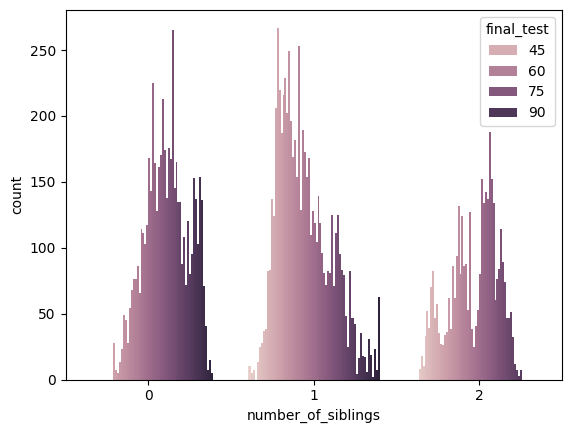

In [405]:
sns.countplot(df, x='number_of_siblings', hue='final_test')

From the above chart, the colours are generally darker for students who have no siblings, which indicates that people with no siblings generally scored better than people with siblings.

In [406]:
df.groupby('number_of_siblings').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
number_of_siblings,,,,,,,,
0,5326.0,75.974277,10.971114,49.0,68.0,76.0,84.0,99.0
1,6494.0,61.787958,13.562872,32.0,51.0,59.0,71.0,100.0
2,3585.0,63.819526,12.196199,36.0,55.0,67.0,73.0,88.0


### direct_admission

<Axes: xlabel='direct_admission', ylabel='count'>

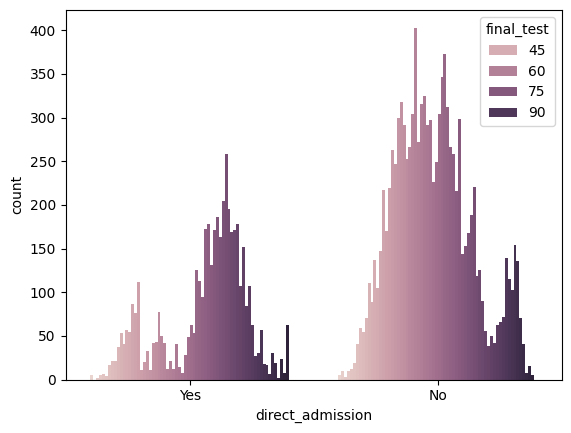

In [407]:
sns.countplot(df, x='direct_admission', hue='final_test')

In [408]:
df.groupby('direct_admission').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
direct_admission,,,,,,,,
No,10857.0,64.989500,13.367099,32.0,55.0,64.0,73.0,99.0
Yes,4548.0,72.359719,14.035955,32.0,67.0,76.0,82.0,100.0


Generally, students who got in through direct admissions have higher grades than students who did not.

### CCA

In [409]:
df['CCA'].value_counts()

CCA
Clubs     3912
Sports    3865
None      3829
Arts      3785
CLUBS      143
NONE       130
ARTS       128
SPORTS     108
Name: count, dtype: int64

When performing a value counts for all the unique values in the CCA column, there appears to be some values that are not formatted in the same way as the rest, leading to values that mean the same thing as other values which may negatively impact the model. This must be rectified before the model is trained.

In [410]:
replaced_CCA = df.replace({
    'CLUBS':'Clubs',
    'SPORTS':'Sports',
    'NONE':'None',
    'ARTS':'Arts'
})

<Axes: xlabel='CCA', ylabel='count'>

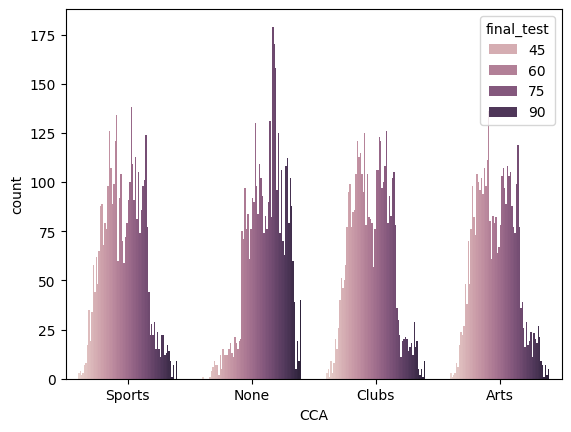

In [411]:
sns.countplot(replaced_CCA, x='CCA', hue='final_test')

From the above, higher scores are observed for students with no CCA. There seems to be no other differences between students in sports, clubs, or arts CCA. To confirm this, .describe is used.

In [412]:
replaced_CCA.groupby('CCA').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
CCA,,,,,,,,
Arts,3791.0,64.061989,13.158185,32.0,54.0,63.0,74.0,100.0
Clubs,3940.0,63.850761,12.972272,32.0,54.0,63.0,74.0,100.0
None,3831.0,76.778648,12.153547,32.0,68.0,78.0,86.0,100.0
Sports,3843.0,64.041894,13.042459,32.0,54.0,64.0,74.0,100.0


### learning_style

From the count plot below, we can see that students with a visual learning style have higher test scores. Most students have auditory learning styles.

<Axes: xlabel='learning_style', ylabel='count'>

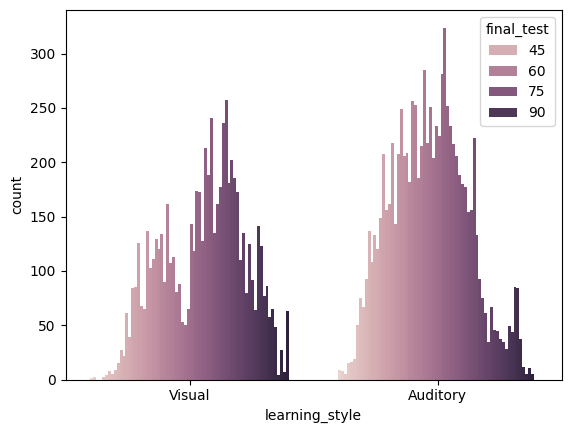

In [413]:
sns.countplot(df, x='learning_style', hue='final_test')

In [414]:
df.groupby('learning_style').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
learning_style,,,,,,,,
Auditory,8847.0,63.888324,13.114772,32.0,54.0,64.0,73.0,99.0
Visual,6558.0,71.586307,13.889588,32.0,60.0,73.0,82.0,100.0


### gender

<Axes: xlabel='gender', ylabel='count'>

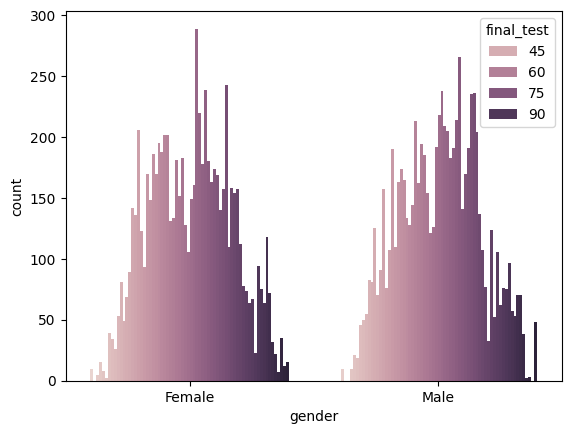

In [415]:
sns.countplot(df, x='gender', hue='final_test')

In [416]:
df.groupby('gender').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Female,7661.0,66.999869,14.045027,32.0,56.0,68.0,78.0,100.0
Male,7744.0,67.329158,13.910100,34.0,56.0,68.0,78.0,100.0


Most of the statistics for the female and male students for their final_test are the same. However, there are an unexpected number of outliers of male students scoring extremely well.

In [417]:
df[df['final_test']==100.0]['gender'].value_counts()

gender
Male      48
Female    15
Name: count, dtype: int64

### tuition

Similar to the CCA column, the tuition column contains data in the wrong format.

In [418]:
df['tuition'].value_counts()

tuition
Yes    8669
No     6643
Y       327
N       261
Name: count, dtype: int64

In [419]:
replaced_tuition = df.replace({
    'Y':'Yes',
    'N':'No'
})

In [420]:
replaced_tuition['tuition'].value_counts()

tuition
Yes    8996
No     6904
Name: count, dtype: int64

In [421]:
replaced_tuition.groupby('tuition').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
tuition,,,,,,,,
No,6689.0,62.864404,14.225541,32.0,51.0,61.0,74.0,100.0
Yes,8716.0,70.466154,12.843240,32.0,61.0,71.0,79.0,100.0


Students who go to tuition have higher grades.

### n_male, n_female

<Axes: xlabel='n_male', ylabel='n_female'>

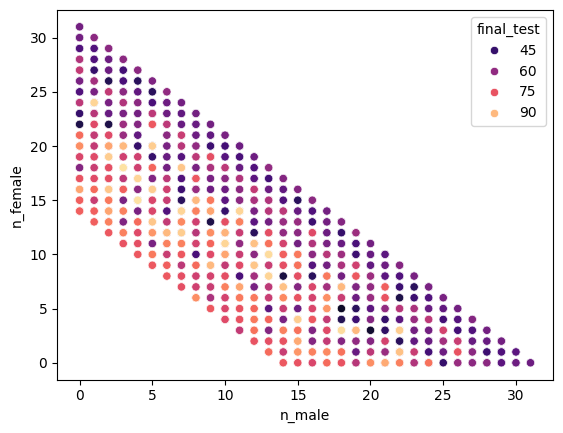

In [422]:
sns.scatterplot(df, x='n_male', y='n_female', hue='final_test',palette='magma')

From the above plot, it appears the values that are closer to the bottom-left are generally better than those that are closer to the top-right. In the middle, there seems to be a zone where students get good grades, but there is no clear indication of the gender of classmates having an impact on grades, as this distribution is seen in both students with more male classmates, and students with more female classmates. This could be an indication that the class size of the student is a factor in the final score, and the gender of those classmates is irrelevant.

In [423]:
df['class_size'] = df['n_male'] + df['n_female']

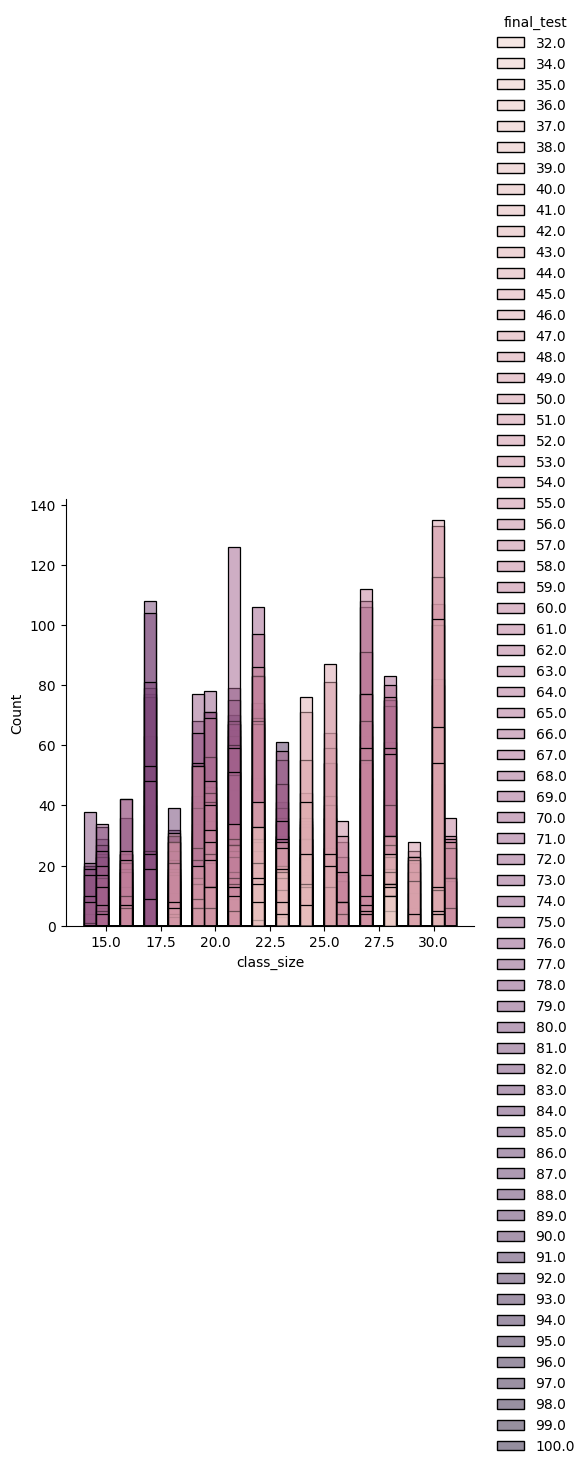

In [424]:
sns.displot(df, x='class_size', hue='final_test')

The above plot confirms that theory. Higher grades are correlated with smaller class sizes.

### age

<Axes: xlabel='age', ylabel='count'>

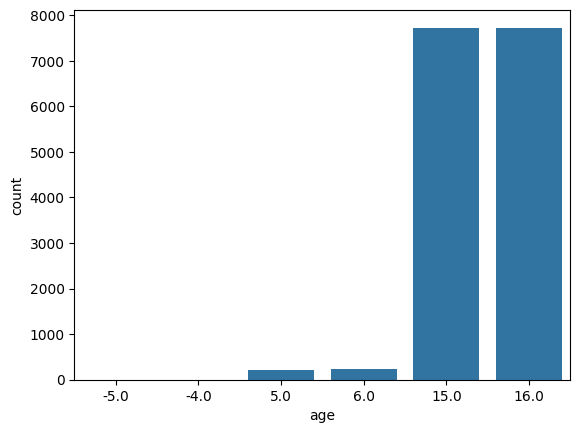

In [425]:
sns.countplot(df, x='age')

There seems to be some errors with the data. Negative values should not exist as age is always positive. The 5.0 and 6.0 could be due to a typo during form input, and could mean 15.0 and 16.0 respectively.

In [426]:
df[df['age']<0]

,index,number_of_siblings,direct_admission,CCA,learning_style,student_id,gender,tuition,final_test,n_male,n_female,age,hours_per_week,attendance_rate,sleep_time,wake_time,mode_of_transport,bag_color,class_size
4513,4513,2,No,Sports,Auditory,RXTBXJ,Male,No,48.0,15.0,4.0,-4.0,2.0,94.0,21:30,5:30,public transport,red,19.0
7932,7932,1,No,Sports,Auditory,UAMI3G,Female,No,52.0,3.0,26.0,-5.0,13.0,92.0,21:00,5:00,public transport,yellow,29.0
8602,8602,0,No,None,Visual,XQMSBU,Female,No,67.0,10.0,18.0,-5.0,18.0,91.0,22:00,6:00,private transport,green,28.0
8663,8663,0,Yes,Arts,Visual,39XWY2,Male,Yes,85.0,17.0,3.0,-5.0,5.0,94.0,23:00,7:00,walk,blue,20.0
8846,8846,2,No,Sports,Auditory,Z33FOS,Female,Yes,74.0,4.0,19.0,-5.0,13.0,90.0,22:00,6:00,private transport,white,23.0


In [427]:
replaced_age = df.copy(deep=True)

In [428]:
replaced_age['age'] = replaced_age['age'].replace({
    5.0:15.0,
    6.0:16.0,
})

The negative values can then be filled in with the mean of the dataset.

In [429]:
replaced_age['age'] = replaced_age['age'].apply(lambda x:(x, replaced_age['age'].mean())[x<0])

In [430]:
replaced_age['age'].value_counts()

age
16.000000    7953
15.000000    7942
15.493962       5
Name: count, dtype: int64

<Axes: xlabel='age', ylabel='final_test'>

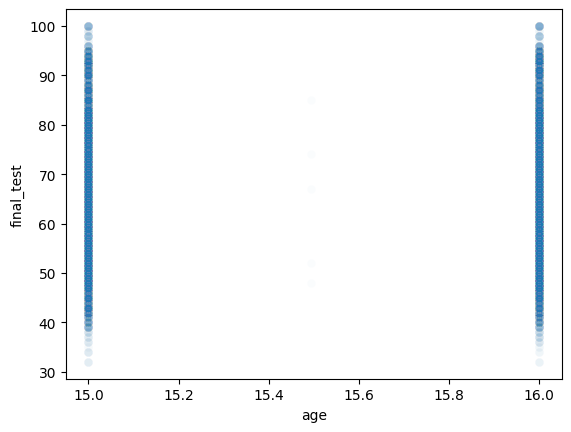

In [431]:
sns.scatterplot(replaced_age, x='age', y='final_test', alpha=0.02)

In [432]:
replaced_age.groupby('age').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
15.000000,7689.0,67.096632,13.838368,32.0,56.0,68.0,77.0,100.0
15.493962,5.0,65.200000,15.352524,48.0,52.0,67.0,74.0,85.0
16.000000,7711.0,67.235248,14.116245,32.0,56.0,68.0,78.0,100.0


There seems to be no meaningful relationship between age and the final test scores.

### hours_per_week

<Axes: xlabel='hours_per_week', ylabel='final_test'>

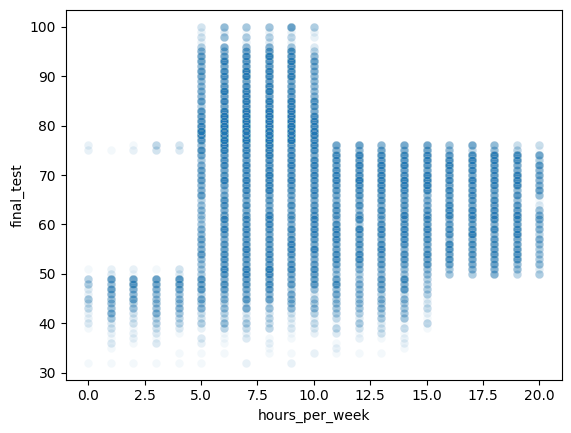

In [433]:
sns.scatterplot(df, x='hours_per_week', y='final_test', alpha=0.05)

From the scatterplot above, the following observations are made:
- Students who spent less than 5 hours studying generally did poorly, with most obtaining less than 50 marks. However, there are a few outliers who scored above 70.
- Marks above 75 were obtained by students who study 5-10 hours per week 
- Students who studied more than 10 hours per week but less than 15 mostly got a maximum of 75 marks.
- Students who exceeded 15 hours per week did not fail but did not do well either, scoring anywhere between 50 - 75 marks. 

### attendance_rate

<Axes: xlabel='attendance_rate', ylabel='final_test'>

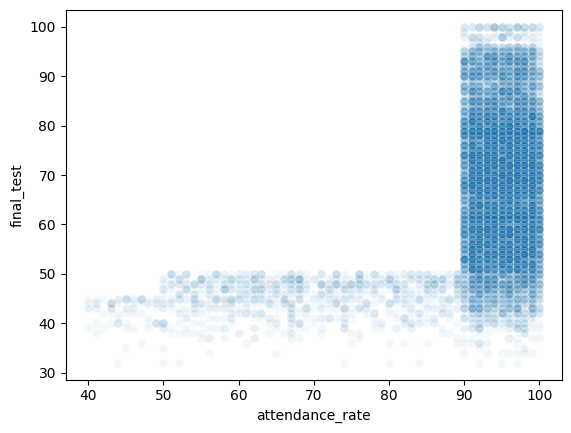

In [434]:
sns.scatterplot(df, x='attendance_rate', y='final_test', alpha=0.05)

Observation: Students who fell below an attendance rate of 90% do not obtain scores above 50.

### sleep_time and wake_time

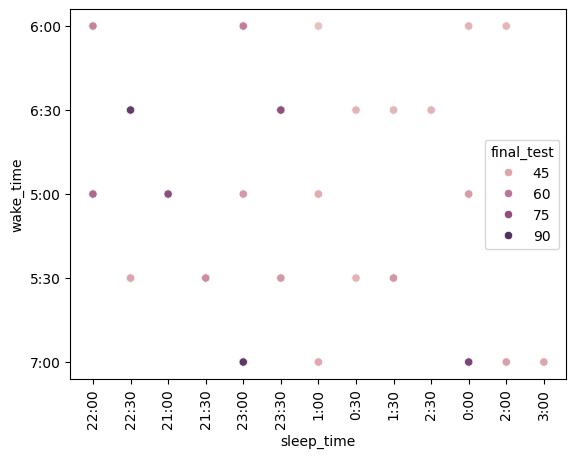

In [435]:
sns.scatterplot(df, x='sleep_time', y='wake_time', hue='final_test')
plt.xticks(rotation=90);

There is no clear pattern of sleep and wake times having an impact on grades. However, using the sleep and wake time, the total hours of sleep can be obtained. To perform mathematical operations, the sleep and wake time first will need to be converted to numbers. The conversion of sleep and wake times into total sleep time is done using two helper functions, then applied to the two columns using a lambda function.

In [436]:
def time_to_float(time):
    new_time = time.replace(':3', ':5')
    new_time = float(new_time.replace(':', r'.'))
    return new_time


def total_sleep(sleep_time, wake_time):

    formatted_sleep_time = time_to_float(sleep_time)
    formatted_wake_time = time_to_float(wake_time)

    if formatted_sleep_time > formatted_wake_time:
        remainder = 24 - formatted_sleep_time
        return formatted_wake_time + remainder
    else:
        return abs(formatted_sleep_time - formatted_wake_time)

In [437]:
df['total_sleep'] = df.apply(lambda row: total_sleep(row['sleep_time'], row['wake_time']), axis=1)

<Axes: xlabel='total_sleep', ylabel='final_test'>

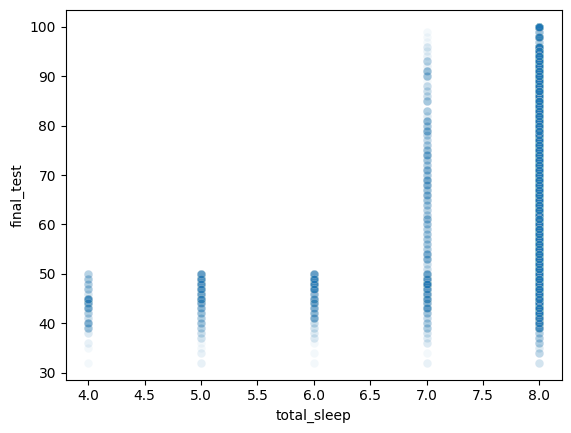

In [438]:
sns.scatterplot(df, x='total_sleep', y='final_test', alpha=0.05)

The above scatterplot shows that students who did not get at least 7 hours of sleep do not score above 50.

In [439]:
df.groupby('total_sleep').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
total_sleep,,,,,,,,
4.0,147.0,43.795918,3.481731,32.0,41.5,44.0,45.5,50.0
5.0,227.0,45.127753,3.862284,32.0,43.0,46.0,48.0,50.0
6.0,233.0,45.596567,3.511114,32.0,43.0,47.0,48.0,50.0
7.0,633.0,61.375987,15.715353,32.0,48.0,59.0,74.0,99.0
8.0,14165.0,68.374585,13.297995,32.0,58.0,69.0,78.0,100.0


### mode_of_transport

There is no meaningful relationship between the mode of transport and the final test results.

In [440]:
df.groupby('mode_of_transport').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
mode_of_transport,,,,,,,,
private transport,6146.0,67.253010,14.018165,32.0,56.0,68.0,78.0,100.0
public transport,6165.0,67.099108,13.926842,32.0,56.0,68.0,78.0,100.0
walk,3094.0,67.123465,14.002827,32.0,56.0,68.0,78.0,100.0


### bag_colour

There is no meaningful relationship between bag color and final test results.

In [441]:
df.groupby('bag_color').describe()['final_test']

,count,mean,std,min,25%,50%,75%,max
bag_color,,,,,,,,
black,2570.0,67.358755,13.873970,32.0,57.0,68.0,77.75,100.0
blue,2550.0,67.114510,13.828498,32.0,56.0,68.0,77.00,100.0
green,2555.0,66.563209,14.133115,32.0,55.0,67.0,77.00,100.0
red,2541.0,67.434475,13.960382,34.0,56.0,68.0,78.00,100.0
white,2531.0,67.144607,13.912361,32.0,56.0,68.0,78.00,100.0
yellow,2658.0,67.368698,14.143768,32.0,56.0,68.0,78.00,100.0


# Pre-processing

In [442]:
df = original_df

For the remaining missing data (attendance rate), I chose to drop the rows that do not contain that data, as it is a small proportion of the total data. The rows that do not contain the final test results are also dropped as the Y label is missing, making the data useless for model training.

In [443]:
def preprocessing(df):
    df['CCA'] = df['CCA'].replace({
        'CLUBS':'Clubs',
        'SPORTS':'Sports',
        'NONE':'None',
        'ARTS':'Arts'
    })
    df['tuition'] = df['tuition'].replace({
        'Y':'Yes',
        'N':'No'
    })
    df['class_size'] = df['n_male'] + df['n_female']
    df['age'] = df['age'].replace({
        5.0:15.0,
        6.0:16.0,
    })
    df['age'] = df['age'].apply(lambda x:(x, df['age'].mean())[x<0])
    df['total_sleep'] = df.apply(lambda row: total_sleep(row['sleep_time'], row['wake_time']), axis=1)
    
    df = df.drop(['sleep_time', 'wake_time', 'student_id', 'n_male', 'n_female', 'bag_color', 'index'], axis=1)
    df = pd.get_dummies(df, drop_first=True, dtype=int)
    df = df.dropna()
    return df

In [444]:
df = preprocessing(df)

In [445]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14648 entries, 0 to 15899
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   number_of_siblings                  14648 non-null  int64  
 1   final_test                          14648 non-null  float64
 2   age                                 14648 non-null  float64
 3   hours_per_week                      14648 non-null  float64
 4   attendance_rate                     14648 non-null  float64
 5   class_size                          14648 non-null  float64
 6   total_sleep                         14648 non-null  float64
 7   direct_admission_Yes                14648 non-null  int32  
 8   CCA_Clubs                           14648 non-null  int32  
 9   CCA_None                            14648 non-null  int32  
 10  CCA_Sports                          14648 non-null  int32  
 11  learning_style_Visual               14648 non-

Now that the data is confirmed to have no missing values and are all in the appropriate data types, we can proceed with splitting the dataset into train-test splits.

In [446]:
from sklearn.model_selection import train_test_split
X = df.drop('final_test', axis=1)
y = df['final_test']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

The data must be scaled first to account for different units. While unecessary for some models, there is no real drawback to scaling data.

In [447]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Model Training

Based on the observations in the exploratory data analysis section, the dataset may be a good for for Random Forest regressors, as some of the features in the generated dataset have sudden 'cut-off' points that may be suited for ensemble models.

In [448]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(scaled_X_train, y_train)
y_pred = model.predict(scaled_X_test)

## Metrics

In [449]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [450]:
MAE

3.780666718858939

In [451]:
RMSE

5.747686212957163

In [452]:
MAPE

0.058981582957803244

In [453]:
results_df = pd.DataFrame(y_test)

In [454]:
results_df['predicted'] = y_pred

In [455]:
results_df.head(20)

,final_test,predicted
12877,88.0,86.226667
15048,95.0,92.730000
4030,54.0,57.850000
15211,66.0,66.780000
5092,79.0,69.416667
4836,72.0,69.050000
3428,92.0,92.630000
3048,69.0,72.360000
9918,58.0,62.250000
10694,68.0,65.070000
